# <center>Assignment 2B – Machine Learning</center>

### <center>Albin Lindqvist (13986236) - Lankun Chen (13591509) – Li Ren (13478516)</center>

#### <center>Group 7</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

# II-b

## Analysis of data

In [2]:
# Load data
train = pd.read_csv("train.csv",index_col = 0)
test = pd.read_csv("test.csv",index_col = 0)
test_label = pd.read_csv("test_label.csv",index_col = 0)


In [3]:
# See non null count, and type of data
train.info()

# See two random entries
train.sample(2)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12870 entries, 13829 to 20137
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        12870 non-null  int64 
 1   job        12870 non-null  object
 2   marital    12870 non-null  object
 3   education  12870 non-null  object
 4   default    12870 non-null  object
 5   balance    12870 non-null  int64 
 6   housing    12870 non-null  object
 7   loan       12870 non-null  object
 8   contact    12870 non-null  object
 9   day        12870 non-null  int64 
 10  month      12870 non-null  object
 11  campaign   12870 non-null  int64 
 12  pdays      12870 non-null  int64 
 13  previous   12870 non-null  int64 
 14  poutcome   12870 non-null  object
 15  y          12870 non-null  object
dtypes: int64(6), object(10)
memory usage: 1.7+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
ID,,,,,,,,,,,,,,,,
11746,53,retired,married,primary,no,0,no,no,cellular,30,jul,1,-1,0,unknown,no
10724,53,entrepreneur,married,tertiary,no,2884,yes,no,unknown,16,may,4,-1,0,unknown,no


##  Pepare Data preprocessing

In [4]:
## List of categorical columns
catetgorical = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome",
]
# List of numerical columns
numerical = ["age", "balance", "campaign", "pdays", "day", "previous"]

### Define a function that can encode category variables and make a Pipeline at the same time.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from typing import Union, List, Dict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils._testing import ignore_warnings
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


X_train = train.drop(["y"], axis=1)
y_train = train["y"]
X_test = test
y_test = test_label


def get_scaler_and_ohe(
    classifier: Union[LogisticRegression, LinearSVC, KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier],
    scaler: Union[Union[StandardScaler, MinMaxScaler], None] = None,
) -> Pipeline:
    """Creates a pipeline, that one hot encoeds the categorical variables and scales the variables (if wanted). The names in the pipe are the same as the parameter names. I.e. scaler and classifier.

    Args:
        classifier (Union[LogisticRegression, LinearSVC, KNeighborsClassifier]): classifier
        scaler (Union[Union[StandardScaler, MinMaxScaler], None], optional): scaler to use. Defaults to None.

    Returns:
        Pipeline: Appropiate pipeline for the given parameters/models.
    """
    if scaler:
        ct = ColumnTransformer(
            [
                ("scaling", scaler, numerical),
                ("onehot", OneHotEncoder(handle_unknown="ignore"), catetgorical),
            ]
        )
        return Pipeline([("scaler", ct), ("classifier", classifier)])
    ct = ColumnTransformer(
        [("onehot", OneHotEncoder(handle_unknown="ignore"), catetgorical)]
    )
    return Pipeline([("scaler", ct), ("classifier", classifier)])

### Define some functions for subsequent modeling and analysis.

In [6]:
@ignore_warnings()
def grid_search_and_test(model: Pipeline, params: Dict[str, List[float]]) -> None:
    """Prints the best parameters found for the model, and the score on the test data"""
    gsc = GridSearchCV(model, param_grid=params, n_jobs=4, error_score=0.0)
    gsc.fit(X_train, y_train)

    print("Best parameters found are:", gsc.best_params_)
    model.set_params(**gsc.best_params_)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    scores = {
        "Accuracy": [accuracy_score(y_test, pred)],
        "Macro Averaged Precision": [precision_score(y_test, pred, average="macro")],
        "Macro Average Recall": [recall_score(y_test, pred, average="macro")],
        "F1 Macro": [f1_score(y_test, pred, average="macro")],
        "Micro Average Precision": [precision_score(y_test, pred, average="micro")],
        "Micro Average Recall": [recall_score(y_test, pred, average="micro")],
        "F1 Micro": [f1_score(y_test, pred, average="micro")],
    }
    score_df = pd.DataFrame(scores)

    return score_df

## 1. Initialize a DecisionTreeClassifier model and perform the following tasks:

### (a) Fit the classifier on the data and report the model accuracy. 
### (b) Report all evaluation metrics listed in Section 3.

In [7]:
# We make a "grid search" with only one (default) parameter to get a nicely formatted table with all scores
grid_search_and_test(
    get_scaler_and_ohe(DecisionTreeClassifier(random_state=100)), {}
).transpose()


Best parameters found are: {}


,0
Accuracy,0.748543
Macro Averaged Precision,0.707152
Macro Average Recall,0.659884
F1 Macro,0.671506
Micro Average Precision,0.748543
Micro Average Recall,0.748543
F1 Micro,0.748543


### (c) Are these models resilient to overfitting when model hyperparameters have not been carefully selected?

#### solution:

We could write codes to see whether hyperparameters influence the generalization of the model.

We select three important parameters(`max_depth`,`max_features`,`max_leaf_nodes`) to show this.

In [8]:
def test_overfit(model: Pipeline)-> None:
    """Define a function to draw learning curve."""
    
    #ignore pandas future warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    figure, axis = plt.subplots(3, 1)
    
    #show what about max_depth
    params_1 = {"classifier__max_depth": np.linspace(2, 30, num=25,dtype=int)}
    gsc_1 = GridSearchCV(model, param_grid=params_1,return_train_score=True,n_jobs=4, error_score=0.0)
    gsc_1.fit(X_train, y_train)
    
    _ = pd.DataFrame(gsc_1.cv_results_).plot(
    x="param_classifier__max_depth",
    y=["mean_test_score", "mean_train_score"],
    ax=axis[0],
    )
    axis[0].set_title("Decision Tree Scores w.r.t. max_depth")
    
    #show what about max_features
    params_2 = {"classifier__max_features": np.linspace(0.05,1,num=25)}
    gsc_2 = GridSearchCV(model, param_grid=params_2,return_train_score=True,n_jobs=4,error_score=0.0)
    gsc_2.fit(X_train, y_train)
    
    _ = pd.DataFrame(gsc_2.cv_results_).plot(
    x="param_classifier__max_features",
    y=["mean_test_score", "mean_train_score"],
    ax=axis[1],
    )
    axis[1].set_title("Decision Tree Scores w.r.t. max_features")
    
    #show what about max_leaf_nodes
    params_3 = {"classifier__max_leaf_nodes": np.linspace(2,50,num=40,dtype=int)}
    gsc_3 = GridSearchCV(model, param_grid=params_3,return_train_score=True,n_jobs=4,error_score=0.0)
    gsc_3.fit(X_train, y_train)
    
    _ = pd.DataFrame(gsc_3.cv_results_).plot(
    x="param_classifier__max_leaf_nodes",
    y=["mean_test_score", "mean_train_score"],
    ax=axis[2],
    )
    axis[2].set_title("Decision Tree Scores w.r.t. max_leaf_nodes")
    
    figure.set_size_inches(10, 10)
    figure.tight_layout()
    plt.show()

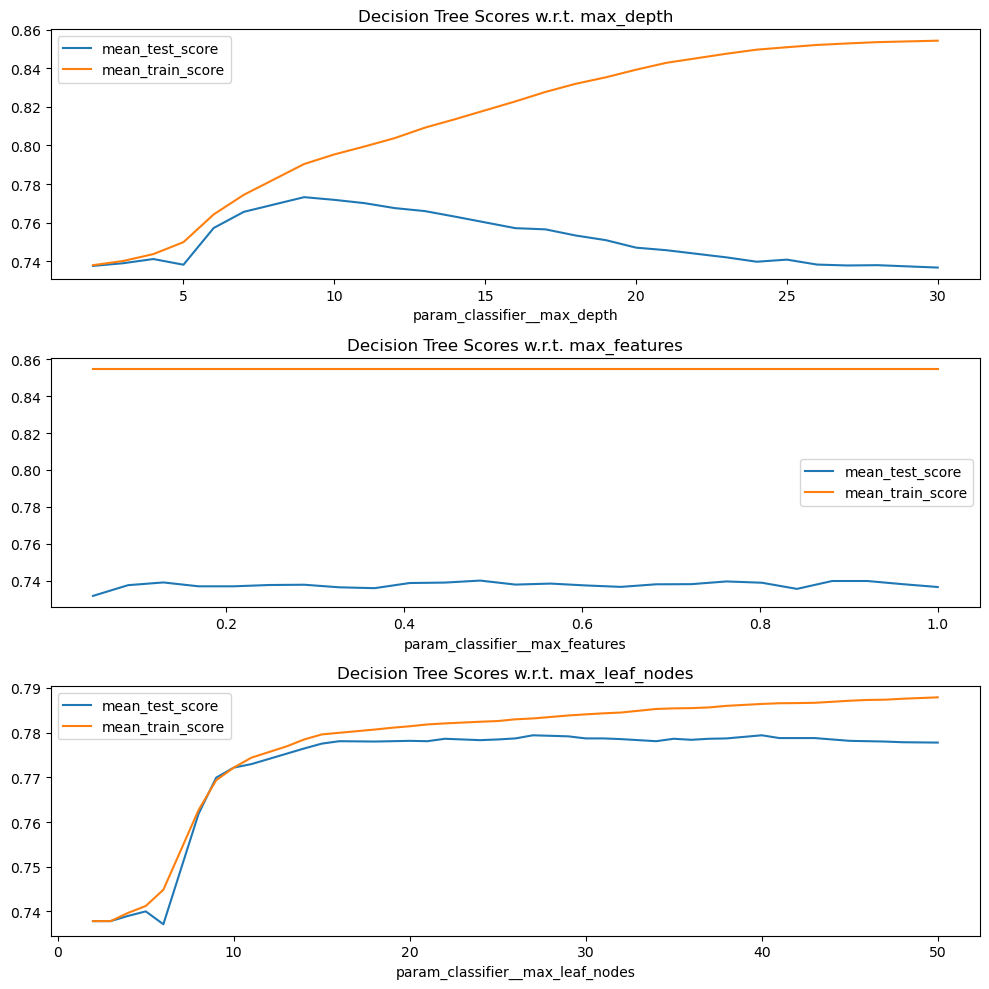

In [9]:
test_overfit(
get_scaler_and_ohe(DecisionTreeClassifier(random_state=100))
)

#### Explain:

Whether the model will overfit relates to the hyperparameter used. 

Random selection of `max_features` basically does not affect generalization.

However, inadvertently selection of `max_depth` and `max_leaf_nodes` have the risk of causing overfitting. Clearly the model tend to overfit if the value exceeds the value near the sweet spot.

### (d)  Perform a grid search on the decision tree model parameters [`max_depth`,`max_features`] to evaluate the optimal values for these parameters. Report model hyperparameters for the best classifier model.

In [10]:
grid_search_and_test(
    get_scaler_and_ohe(DecisionTreeClassifier(random_state=100)),
    {
        "classifier__max_depth": np.linspace(2, 30, num=25,dtype=int),
        "classifier__max_features": ["sqrt", "log2"] + list(np.linspace(0.05,1,num=15)),
    },
).transpose()


Best parameters found are: {'classifier__max_depth': 9, 'classifier__max_features': 0.7964285714285714}


,0
Accuracy,0.784666
Macro Averaged Precision,0.762951
Macro Average Recall,0.701093
F1 Macro,0.717777
Micro Average Precision,0.784666
Micro Average Recall,0.784666
F1 Micro,0.784666


### In no more than 50 words, explain your observations and your assessment of the classifier.

The optimal value of `max_depth` is 9, and there is a risk of overfitting/underfitting if it exceeds/below this value.

Micros are higher, reflecting it might be biased toward the minority class. Decision tree performs better than linear models according to the macro-average f1 value when handling this imbalanced dataset.

## 2. Initialize a RandomForestClassifier model and perform the following tasks:

### (a) Fit the classifier on the data and report the model accuracy.
### (b) Report all evaluation metrics listed in Section 3.

In [11]:
grid_search_and_test(
    get_scaler_and_ohe(RandomForestClassifier(random_state=100)), {}
).transpose()


Best parameters found are: {}


,0
Accuracy,0.761827
Macro Averaged Precision,0.724637
Macro Average Recall,0.681652
F1 Macro,0.694105
Micro Average Precision,0.761827
Micro Average Recall,0.761827
F1 Micro,0.761827


### (c) Answer the following questions:

#### 1. How are decision tree classifiers different from random forests on a structural level? (max.50 words)

Decision tree is a tree model composed of decision nodes that split into multiple branches and leaf nodes that represent results by judging features.

Random forest is a collection of slightly different decision trees. Classification is performed by averaging the decision probabilities of all trees.

#### 2. Where would you choose decision trees over random forests and vice-versa? Demonstrate this using an appropriate example from your data

##### Example : Visualize the decision tree based on our dataset.

In [12]:
from sklearn import tree

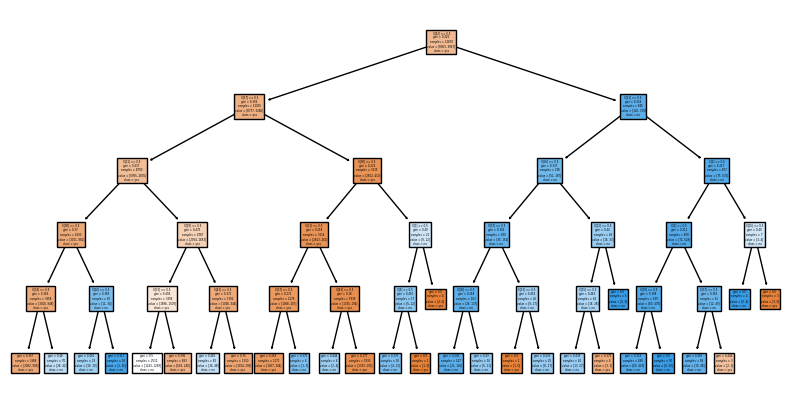

In [13]:
dec = get_scaler_and_ohe(DecisionTreeClassifier(max_depth = 5, random_state=100))
dec.fit(X_train, y_train)
decision_tree = dec.steps[1][1]
fig = plt.figure(figsize=(10,5))
_ = tree.plot_tree(decision_tree,   
                   class_names=["yes","no"],
                   filled=True)

##### Explain:

Decision trees are the preferred choice when we need a compact representation of the decision process, because it is impossible for us to explain an extremely large number of trees when using random forests. Decision tree performs better when we need to visualize the decision process to others.

#### 3. Is accuracy an appropriate evaluation metric for this classification task? if yes, in what kind of data may it not be a good metric? Justify your answer in less than 20 words.

In [14]:
train["y"].value_counts()


no     8903
yes    3967
Name: y, dtype: int64

In [15]:
from sklearn.metrics import confusion_matrix
pipeline = get_scaler_and_ohe(RandomForestClassifier(random_state=100))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
con = confusion_matrix(y_test,y_pred)

In [16]:
print(f"Confusion matrix of Random Forest:\n{con}")

Confusion matrix of Random Forest:
[[2644  325]
 [ 697  625]]


##### Explain:

No. 70% of samples belong to the "no" class, which is a dataset with imbalanced class.

### (d) Perform a grid search on the random forest model parameters `max_depth`,`max_features`, `n_estimators` to evaluate the optimal values for these parameters. Report model parameters for your best classifier model.

In [17]:
grid_search_and_test(
    get_scaler_and_ohe(RandomForestClassifier(random_state=100)),
    {
        "classifier__max_depth": np.linspace(2, 30, num=10, dtype=int),
        "classifier__max_features": ["sqrt", "log2", None],
        "classifier__n_estimators": [100, 200, 500],
    },
).transpose()

Best parameters found are: {'classifier__max_depth': 11, 'classifier__max_features': None, 'classifier__n_estimators': 100}


,0
Accuracy,0.784199
Macro Averaged Precision,0.772394
Macro Average Recall,0.690056
F1 Macro,0.708283
Micro Average Precision,0.784199
Micro Average Recall,0.784199
F1 Micro,0.784199


### In no more than 50 words, explain your observations and your assessment of the classifier:

The value of the macro-average is significantly lower than the micro-average, which is caused by the minority class "yes".

The random forest performs better than decison tree according to macro f1, this may be due to the increase in the value of `max_depth`.